<a href="https://colab.research.google.com/github/Mingzhe-W/zk_lending/blob/main/zkloading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preparation

In [1]:
# Importing necessary Libraries
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.regularizers import l2
from sklearn import metrics
from sklearn .metrics import accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading and Exploring Data
df = pd.read_csv("/content/train.csv")

# Dropping irrelevant features
df_c = df.copy()
df_c.drop(['ID' ,'Customer_ID' ,'Month' ,'Name', 'Type_of_Loan', 'Credit_History_Age', 'SSN'], axis=1, inplace=True)

# Dropping all observations with more than 3 missing values
size_before_cleaning = df_c.shape
df_c = df_c[df_c.isnull().sum(axis=1) < 3]
# print("{} Records dropped".format(size_before_cleaning[0] - df_c.shape[0]))

def filter_general(value):
    if '-' in str(value):
        return str(value).split('-')[1]
    elif '_' in str(value):
        return str(value).split('_')[0]
    else:
        return str(value)

def filter_delayed_payments(value):
    if "__" in str(value):
        return str(value).split("__")[1]
    elif '_' in str(value):
        return str(value).replace("_", "")
    elif str(value) == '_':
        return str(value)
    else:
        return str(value)

def Amount_invested_monthly(col):
    if "__" in str(col):
        return str(col).split("__")[1]
    else:
        return str(col)

df_c["Amount_invested_monthly"]=df_c["Amount_invested_monthly"].apply(Amount_invested_monthly)
df_c["Amount_invested_monthly"]=df_c["Amount_invested_monthly"].astype("float")

df_c["Changed_Credit_Limit"]=df_c["Changed_Credit_Limit"].apply(lambda x:x.split("-")[-1])
df_c.drop(df_c[df_c["Changed_Credit_Limit"]=="_"].index,inplace=True)
df_c["Changed_Credit_Limit"]=df_c["Changed_Credit_Limit"].astype("float")

df_c.drop(df_c[df_c["Monthly_Balance"]=='__-333333333333333333333333333__'].index,inplace=True)
for i in ['Age', 'Annual_Income', 'Num_of_Loan', 'Outstanding_Debt', 'Monthly_Balance']:
    df_c[i] = df_c[i].apply(filter_general)
    df_c[i] = df_c[i].astype(np.float64)
    # print(i + " Successfully Cleaned")

df_c['Num_of_Delayed_Payment'] = df_c['Num_of_Delayed_Payment'].apply(filter_delayed_payments)
df_c['Num_of_Delayed_Payment'] = df_c['Num_of_Delayed_Payment'].astype(np.float64)

df_c['Occupation'] = df_c['Occupation'].replace('_______', np.nan)
df_c['Occupation'] = df_c['Occupation'].fillna(np.random.choice(pd.Series(['Scientist', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'])))

df_c['Credit_Mix'] = df_c['Credit_Mix'].replace('_', np.nan)
df_c['Credit_Mix'] = df_c['Credit_Mix'].fillna(np.random.choice(pd.Series(['Standard', 'Good', 'Bad'])))

df_c['Payment_of_Min_Amount'] = df_c['Payment_of_Min_Amount'].replace('NM', np.nan)
df_c['Payment_of_Min_Amount'] = df_c['Payment_of_Min_Amount'].fillna(np.random.choice(pd.Series(['Yes', 'No'])))

df_c['Payment_Behaviour'] = df_c['Payment_Behaviour'].replace('!@9#%8', np.nan)
df_c['Payment_Behaviour'] = df_c['Payment_Behaviour'].fillna(np.random.choice(pd.Series(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments', 'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments',
       'Low_spent_Medium_value_payments'])))

for i in ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Amount_invested_monthly']:
    df_c[i].fillna(df_c[i].median(), inplace=True)

df_c['Monthly_Balance'].fillna(df_c['Monthly_Balance'].median(), inplace=True)

# # Data Visualization and Statistical insights
# df_c.describe(include='all').style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})
# df_c.hist(bins=200,figsize=[20,10])

numeric_cols = df_c.select_dtypes(exclude = "object").columns
cat_cols = df_c.select_dtypes(include = "object").columns
# Dealing with outliers¶
def box_plot(df_c, num_cols):
    plt.figure(figsize=(20, 15))
    for i in range(len(num_cols)):
        if i == 16:
            break
        else:
            plt.subplot(4,4, i+1)
            l = num_cols[i]
            sns.boxplot(df_c[l], palette="flare")

# IQR = Quartile3 – Quartile1
# upper = Q3 +1.5*IQR
# lower = Q1 – 1.5*IQR
df_c_n = df_c.copy()
for i in numeric_cols:
    ''' Detection '''
    # IQR
    Q1 = np.percentile(df_c_n[i], 0.05,interpolation = 'midpoint')
    Q3 = np.percentile(df_c_n[i], 99.95,interpolation = 'midpoint')
    # print("@ Feature " + i + "...")
    # print("Old Shape: ", df_c_n.shape)
    df_c_n[numeric_cols] = df_c_n[numeric_cols][(df_c_n[i] < Q3) & (df_c_n[i] > Q1)]
    df_c_n.dropna(inplace=True)
    # print("New Shape: ", df_c_n.shape)
df_c_n.drop(df_c_n[df_c_n["Age"] >= 80].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Annual_Income"] >= 500000].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Num_Bank_Accounts"] >= 20].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Num_Credit_Card"] >= 50].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Num_of_Loan"] >= 20].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Interest_Rate"] >= 35].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Num_of_Delayed_Payment"] >= 30].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Num_Credit_Inquiries"] >= 100].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Total_EMI_per_month"] >= 2000].index, inplace=True)
df_c_n.drop(df_c_n[df_c_n["Amount_invested_monthly"] >= 1000].index, inplace=True)

# Handling numirical data
numeric_cols = df_c.select_dtypes(exclude = "object").columns
cat_cols = df_c.select_dtypes(include = "object").columns
# print(numeric_cols)
# print(cat_cols)
df_num_clean = df_c_n[numeric_cols].copy()
cols = numeric_cols

def RobustScaling(df_num, cols):
    scaler = preprocessing.RobustScaler()
    robust_df_temp = scaler.fit_transform(df_num)
    robust_df_temp = pd.DataFrame(robust_df_temp, columns =cols)
    return robust_df_temp

robust_scaled = RobustScaling(df_num_clean, numeric_cols)

clean_df = df_c.copy()
clean_df.drop(labels=numeric_cols, axis="columns", inplace=True)
clean_df[numeric_cols] = robust_scaled[numeric_cols]
# clean_df.head()

# Categorical data encoding
clean_df['Credit_Score'].replace({"Poor":0, "Standard":1, "Good":1}, inplace=True)
clean_df['Credit_Mix'].replace({"Bad":0, "Standard":1, "Good":2}, inplace=True)
clean_df['Payment_of_Min_Amount'].replace({"Yes":1, "No":0}, inplace=True)
clean_df = pd.get_dummies(clean_df, columns = ['Occupation', 'Payment_Behaviour'])
clean_df = clean_df.drop("Credit_Mix",'columns')

for i in numeric_cols:
    clean_df[i].fillna(method='ffill', inplace=True)

# cut part of the dataset
clean_df = clean_df[:2000]
print("data cleaning completed. results as follows:")
clean_df.head()
print("data info:")
clean_df.info()


data cleaning completed. results as follows:
data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 2044
Data columns (total 39 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Payment_of_Min_Amount                               2000 non-null   int64  
 1   Credit_Score                                        2000 non-null   int64  
 2   Age                                                 2000 non-null   float64
 3   Annual_Income                                       2000 non-null   float64
 4   Monthly_Inhand_Salary                               2000 non-null   float64
 5   Num_Bank_Accounts                                   2000 non-null   float64
 6   Num_Credit_Card                                     2000 non-null   float64
 7   Interest_Rate                                       2000 non-null   float64
 8   Num_of_Loan           

Model Setup Part

In [2]:
!pip install tenseal
!pip install onnx
!pip install ezkl

In [3]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

Data Preparation

In [4]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

def credit_data():
    data = clean_df.copy()
    # extract labels
    y = torch.tensor(clean_df['Credit_Score'].values).float().unsqueeze(1)
    data = data.drop("Credit_Score",'columns')
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)

x_train, y_train, x_test, y_test = credit_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([1400, 38])
y_train has shape: torch.Size([1400, 1])
x_test has shape: torch.Size([600, 38])
y_test has shape: torch.Size([600, 1])
#######################################


Training a Logistic Regression Model

In [5]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [6]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [7]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 10

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.6716759204864502
Loss at epoch 2: 0.6314529776573181
Loss at epoch 3: 0.6151984333992004
Loss at epoch 4: 0.6052364706993103
Loss at epoch 5: 0.5981099009513855
Loss at epoch 6: 0.5925564765930176
Loss at epoch 7: 0.5879755616188049
Loss at epoch 8: 0.5840469598770142
Loss at epoch 9: 0.5805886387825012
Loss at epoch 10: 0.5774913430213928


In [8]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.7283333539962769


Encrypted Evaluation

In [9]:
class EncryptedLR:

    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


eelr = EncryptedLR(model)

In [10]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [11]:
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 1 seconds


In [12]:
# (optional) encrypt the model's parameters
# eelr.encrypt(ctx_eval)

In [13]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()

    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1

    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)


encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

Evaluated test_set of 600 entries in 6 seconds
Accuracy: 211/600 = 0.3516666666666667
Difference between plain and encrypted accuracies: 0.37666669487953186


Training an Encrypted Logistic Regression Model on Encrypted Data

In [14]:
class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [15]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [16]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 24 seconds


Distribution on plain data:


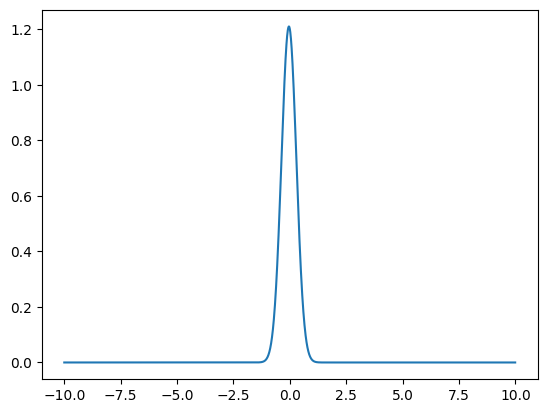

Distribution on encrypted data:


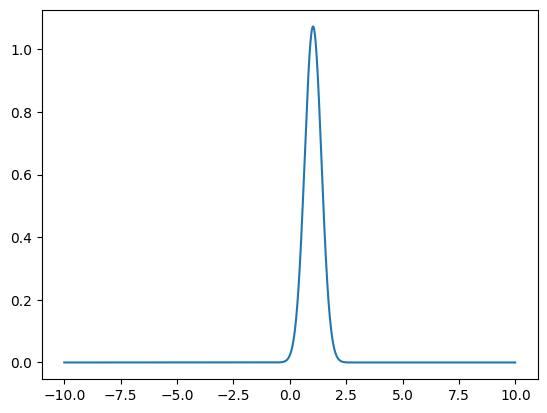

In [17]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

In [18]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)

    # if you want to keep an eye on the distribution to make sure
    # the function approximation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)

    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.4466666579246521
Accuracy at epoch #1 is 0.4933333396911621
Accuracy at epoch #2 is 0.528333306312561
Accuracy at epoch #3 is 0.6499999761581421
Accuracy at epoch #4 is 0.47833332419395447
Accuracy at epoch #5 is 0.596666693687439
Accuracy at epoch #6 is 0.5616666674613953
Accuracy at epoch #7 is 0.5616666674613953
Accuracy at epoch #8 is 0.5583333373069763
Accuracy at epoch #9 is 0.7300000190734863
Accuracy at epoch #10 is 0.7300000190734863

Average time per epoch: 206 seconds
Final accuracy is 0.7300000190734863
Difference between plain and encrypted accuracies: -0.0016666650772094727
Oh! We got a better accuracy when training on encrypted data! The noise was on our side...


Using EZKL to do proof of inference

In [19]:
# define the path of all the necessary file
import os
import ezkl

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [26]:
import json
import onnx
# # After training, export to onnx (network.onnx) and create a data file (input.json)
x = torch.ones([1, 38], dtype=torch.float32)
x = x.reshape([1, 38])

# print(x)
model_to_EZKL = LR(n_features)
model_to_EZKL.lr.weight.data = torch.tensor([eelr.weight])
model_to_EZKL.lr.bias.data = torch.tensor(eelr.bias)

# test_lr = LR(n_features)

    # Export the model
torch.onnx.export(model_to_EZKL,               # model being run
                  x,                   # model input (or a tuple for multiple inputs)
                  model_path,            # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data_json = dict(input_data = [data_array])

print(data_json)

    # Serialize data into file:
json.dump( data_json, open(data_path, 'w' ))

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

{'input_data': [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]}


EZKL setup

In [40]:
ezkl.gen_settings(model_path, settings_path)
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
# srs path
res = ezkl.get_srs(srs_path, settings_path)
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )
assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

EZKL generate proof

In [41]:
res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "single",
    )

assert os.path.isfile(proof_path)

EZKL verify the proof

In [42]:
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

verified
